# Importing packages

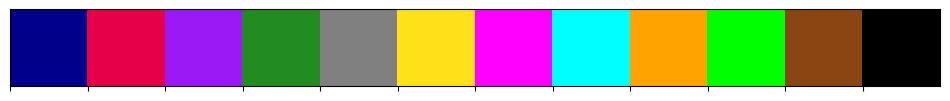

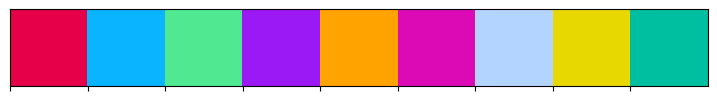

In [2]:
# Importing necessary packages:

from glob import glob
import numpy as np
import pandas as pd

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from polyphys.visualize import plotter
from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS as AC
from polyphys.visualize.plotter import DUTCH_FEILD_COLORS as DF_colors
from polyphys.visualize import tuner
from polyphys.manage.parser import \
    SumRuleCyl, TransFociCyl, TransFociCub, HnsCub
from polyphys.manage import organizer
#from polyphys.analyze import measurer
from polyphys.manage import utilizer
dmon_l_c_pal = ['orange', 'darkgoldenrod', 'forestgreen']
sns.palplot(AC)
sns.palplot(DF_colors)

# Per project

## Importing dataset

In [3]:
# Project details
#project = 'HnsCub'
#project = 'TransFociCyl'
#project = 'SumRuleCyl'
project = 'TransFociCub'
# loading databases:
allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
#allInOne_db = '/Users/amirhsi_mini/research_data/'+project+'/allInOne/' # relative
space_dbs = glob(allInOne_db + PD[project]['space_pat'])
print(space_dbs)
pair_dist_properties = ['pairDistHistFoci', 'pairDistRdfFoci']
prop = pair_dist_properties[1]
# LOad data
dist_map = '-'.join(['allInOne', project, PD[project]['group'], 'pairDistStats.parquet.brotli'])
dist_map = allInOne_db + dist_map
dist_map = pd.read_parquet(dist_map)
# a sorted list of unique spaces in the dataset
spaces = dist_map['space'].unique()
spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
project_titles = {}
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project == 'TransFociCub':
        project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                             fr"$N_M={s_info.nmon_large},$ " +
                             fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
    elif project == 'TransFociCyl':
        project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                             fr"$N_M={s_info.nmon_large},$ " +
                             fr"${{D}}/{{a_m}}={s_info.dcyl},$ " +
                             fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
    elif project == 'SumRuleCyl':
        project_title_style = (fr"$N={s_info.nmon},$ " +
                             fr"$D={s_info.dcyl},$ " +
                             fr"$a_c={s_info.dcrowd}$")
    elif project == 'HnsCub':
        project_title_style = (fr"$N={s_info.nmon},$ " +
                             fr"$N_{{hns}}={s_info.nhns},$ " +
                             fr"a_c={s_info.dcrowd}$")
    else:
        raise ValueError(f"Project: '{project}' is not defined.")
    project_titles = project_title_style
divisor = 0.025
round_to = 3
dist_map['phi_c_bulk_round'] = dist_map['phi_c_bulk'].apply(
        utilizer.round_up_nearest, args=[divisor, round_to]
        )
# phi_c to drop
phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
dist_map = dist_map.loc[~dist_map['phi_c_bulk_round'].isin(phi_c_to_drop),:]
dist_map.reset_index(inplace=True, drop=True)
# Dropping pair distance cols of `prop_to_drop`
prop_to_drop = pair_dist_properties[0]
cols_to_drop = [col for col in dist_map.columns if col.startswith(prop_to_drop)]
dist_map.drop(columns=cols_to_drop, inplace=True)
dist_map['bin_center-norm-r-dmon_large'] = \
    dist_map['bin_center'] / dist_map['dmon_large']
dist_map['bin_center-norm'] = \
    dist_map['bin_center'] / dist_map['bin_center'].max()
# renaming pair distance cols of `prop`
pair_tags = {
    col: col.split('-')[1] for col in dist_map.columns if 'genDist' in col
    }
dist_map.rename(columns=pair_tags, inplace=True)
# Now, just keep the new col names for melting
pair_tags = list(pair_tags.values())
pair_names = {tag: organizer.sort_by_alphanumeric(tag)[1::2] for tag in pair_tags}
pair_names = {tag:
    r"$({0},{1},{2})$".format(int(locs[0]), int(locs[1]), int(locs[2])) for tag, locs in pair_names.items()}
attributes = PD[project]['equil_attributes'].copy()
attributes.extend(['bin_center', 'bin_center-norm', 'bin_center-norm-r-dmon_large'])
sel_cols = attributes + pair_tags
pair_dist = dist_map[sel_cols].melt(
    id_vars=attributes,
    value_vars=pair_tags,
    var_name=prop
)
pair_dist.loc[:, 'genomic_distance'] = pair_dist.loc[
    :, 'pairDistRdfFoci'].str.split(r'(\d+\.*\d*)', regex=True).apply(
    lambda str_list: int(float(str_list[-2])))

['../../Datasets/TransFociCub-allInOne/ns400nl5al3ac1-bug-chainSize-acf.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al5ac1-bug-chainSize-acf.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al1ac1-bug-chainSize.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al3ac1-whole-equilProps.csv', '../../Datasets/TransFociCub-allInOne/ns400nl5al5ac1-whole-equilProps.csv', '../../Datasets/TransFociCub-allInOne/ns400nl5al1ac1-bug-chainSize-acf.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al1ac1-whole-equilProps.csv', '../../Datasets/TransFociCub-allInOne/ns400nl5al5ac1-bug-chainSize.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al3ac1-bug-chainSize.parquet.brotli']


## Genomic position distance per d_mon

In [ ]:
height = 4
aspect = 1 * 16/9 # 1.5 * 1.618 # Golden ratio
font_scale = 1.2
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
plot_context = 'talk'
color_palette = 'colorblind'
#color_palette = 'viridis'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.2,
    'edgecolor': 'black',
    'markerscale': 2
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.93, 'ha': 'center'}

# Filter bin_Cetners based on rdf values
bin_center_cond = (pair_dist['bin_center-norm']<=0.3)
dmon_large_cond = (pair_dist['dmon_large'].isin([1,3,5]))
phi_c_cond = (pair_dist['phi_c_bulk_round'].isin([0, 0.1]))
conds = bin_center_cond & dmon_large_cond & phi_c_cond
data = pair_dist.loc[conds,:]
data.reset_index(inplace=True, drop=True)


x_prop = 'bin_center-norm-r-dmon_large'
y_prop = 'value'

row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())

col_attr = 'dmon_large'
col_order = sorted(data[col_attr].unique())

style_attr = 'genomic_distance'
style_order = sorted(data[style_attr].unique())

hue_attr = 'pairDistRdfFoci'
hue_order = sorted(data[hue_attr].unique(),key=organizer.sort_by_alphanumeric)
hue_labels = [pair_names[hue] for hue in hue_order]


sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )
plot_details = {
    'TransFoci': [
        ('paper', (0.65,0.9)),
        ('talk', (0.65,0.84))
    ],
}
for (title_style, leg_anch) in plot_details['TransFoci']:
    f_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        style=style_attr,
        style_order=style_order,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        kind='line',
        height=height,
        aspect=aspect,
        palette=color_palette,
        facet_kws=facet_kws,
        legend='full',
        alpha=0.7,
        lw=2,
        errorbar=None,
        )

    vline_patch = tuner.ls_handler([r'$r=a_M$'], [':'], color='black', lw=2)
    legend_labels = ['$(n_1, n_2,\Delta n)$'] + hue_labels + \
                    [AL[style_attr]] + list(style_order)
    for idx, new_label in enumerate(legend_labels):
        f_grid._legend.legendHandles[idx].set_linewidth(2)
        f_grid._legend.texts[idx].set_ha('left')
        f_grid._legend.texts[idx].set_text(new_label)
    f_grid.set_titles('')
    f_grid.set(yticks=np.arange(0,0.08,0.02))
    row_col_pairs = list(itertools.product(row_order,col_order))
    for idx, (ax, (row_name, col_name)) in enumerate(zip(f_grid.axes.flat,row_col_pairs)):
        ax.text(0.75,0.9,
                AL[row_attr] + fr"$={row_name},$ " + \
                AL[col_attr] + fr"$={col_name}$",
                color='black',
                ha="center",
                va="center",
                bbox=global_bbox,
                transform=ax.transAxes)
    f_grid.set_axis_labels(AL[x_prop], AL[hue_attr])
    f_grid.map(
        plt.axvline, x=1.0, label=r"$r=a_M$", lw=2, ls=':', 
        color='black', zorder=0
    )
    f_grid.figure.legend(
        handles=vline_patch,
        loc='upper left',
        bbox_to_anchor=(0.8, 0.18),
        **legend_kws
    )
    if title_style == 'talk':
        f_grid.fig.suptitle(project_title_style, **fig_title_kws)
    sns.move_legend(f_grid,
                    loc='upper left',
                    bbox_to_anchor=(0.8, 0.91),
                    **legend_kws)
    f_grid.tight_layout(w_pad=0.2, h_pad=0.3)
    output = "-".join(
            ["Genomic_position", title_style, col_attr, row_attr,
             hue_attr, project])
    f_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

## Genomic distance matters not genomic position

In [ ]:
height = 4
aspect = 1 * 16/9 # 1.5 * 1.618 # Golden ratio
font_scale = 1.8
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
plot_context = 'talk'
color_palette = 'colorblind'
#color_palette = 'viridis'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.2,
    'edgecolor': 'black',
    'markerscale': 2
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.93, 'ha': 'center'}

bin_center_cond = (pair_dist['bin_center']<=20)
dmon_large_chosen =[5]
dmon_large_cond = (pair_dist['dmon_large'].isin(dmon_large_chosen))
phi_c_chosen = [0, 0.1, 0.2]
phi_c_cond = (pair_dist['phi_c_bulk_round'].isin(phi_c_chosen))
conds = bin_center_cond & dmon_large_cond & phi_c_cond
data = pair_dist.loc[conds,:]
data.reset_index(inplace=True, drop=True)

x_prop = 'bin_center-norm-r-dmon_large'
y_prop = 'value'

hue_attr = 'pairDistRdfFoci'
hue_order = sorted(data[hue_attr].unique(),key=organizer.sort_by_alphanumeric)
hue_labels = [pair_names[hue] for hue in hue_order]

col_attr = 'phi_c_bulk_round'
col_order = sorted(data[col_attr].unique())

row_attr = 'genomic_distance'
row_order = sorted(data[row_attr].unique())

plot_details = {
    'TransFoci': [
        ('paper', (0.65,0.9)),
        ('talk', (0.65,0.84))
    ],
}
for (title_style, leg_anch) in plot_details['TransFoci']:
    f_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        row=row_attr,
        row_order=row_order,
        col=col_attr,
        col_order=col_order,
        hue=hue_attr,
        kind='line',
        height=height,
        aspect=aspect,
        palette=color_palette,
        facet_kws=facet_kws,
        legend='full',
        alpha=0.7,
        ls='--',
        lw=3,
        errorbar=None,
        )
    legend_labels = ['$(n_1, n_2,\Delta n)$'] + hue_labels
    for idx, new_label in enumerate(legend_labels[1:]):
        f_grid._legend.legendHandles[idx].set_linewidth(2)
        f_grid._legend.texts[idx].set_ha('left')
        f_grid._legend.texts[idx].set_text(new_label)

    f_grid.map(plt.axvline, x=1.0, label=r"$r=a_M$", lw=2, ls=':', color='black', zorder=0)
    f_grid.set_ylabels(AL[hue_attr])
    f_grid.set_xlabels(AL[x_prop])
    f_grid.set_titles('')
    f_grid.set(yticks=np.arange(0,0.12,0.02))
    row_col_pairs = list(itertools.product(row_order,col_order))
    for idx, (ax, (row_name, col_name)) in enumerate(zip(f_grid.axes.flat,row_col_pairs)):
        ax.text(0.75,0.9,
                AL[row_attr] + fr"$={row_name},$ " + \
                AL[col_attr] + fr"$={col_name}$",
                color='black',
                ha="center",
                va="center",
                bbox=global_bbox,
                transform=ax.transAxes)
    if title_style == 'talk':
        f_grid.fig.suptitle(
            project_title_style +
            f", ${{a_M}}/{{a_m}}={dmon_large_chosen[0]}$",
            **fig_title_kws)
    vline_patch = tuner.ls_handler([r'$r=a_M$'], [':'], color='black', lw=2)
    f_grid.figure.legend(
        handles=vline_patch,
        loc='upper left',
        bbox_to_anchor=(0.8, 0.3),
        **legend_kws
    )
    sns.move_legend(
        f_grid,
        title=legend_labels[0],
        loc='upper left',
        bbox_to_anchor=(0.8, 0.9),
        **legend_kws)
    f_grid.tight_layout(w_pad=0.2, h_pad=0.2)
    output = "-".join(
            ["Genomic_distance_matters", f'dmon_large{dmon_large_chosen[0]}',
             title_style, col_attr, row_attr, hue_attr, project]
        )
    f_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

## Genomic-distance-averaged data

### Averaging over dataset

In [4]:
group_by_cols = pair_dist.columns.to_list()
group_by_cols.remove('value')
group_by_cols.remove('pairDistRdfFoci')
agg_dict = ['last'] * len(group_by_cols)
agg_dict = dict(zip(group_by_cols,agg_dict))
agg_dict['value'] = 'mean'
# averaging over genomic distance:
gen_dist = pair_dist.groupby(group_by_cols).agg(agg_dict)
gen_dist.reset_index(inplace=True, drop=True)
gen_dist.rename(columns={'value': 'pairDistRdfGenDistAvg'}, inplace=True)

In [9]:
group_by_cols = PD[project]['equil_attributes'].copy()
group_by_cols.extend(['genomic_distance'])
gen_dist['pairDistRdfGenDistAvg-norm_by_max'] = gen_dist['pairDistRdfGenDistAvg'] / gen_dist.groupby(group_by_cols)['pairDistRdfGenDistAvg'].transform('max')

### Genomic distance explained

#### detailed

In [ ]:
height = 4
aspect = 1 * 16/9 # 1.5 * 1.618 # Golden ratio
font_scale = 1.2
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
plot_context = 'talk'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': False,
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.2,
    'edgecolor': 'black',
    'markerscale': 2
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.95, 'ha': 'center'}

# Filter bin_Cetners based on rdf values
bin_center_cond = (gen_dist['bin_center-norm']<=0.4)
dmon_large_chosen = [1, 3, 5]
dmon_large_cond = (gen_dist['dmon_large'].isin(dmon_large_chosen))
phi_c_chosen = [0, 0.1, 0.3]
phic_cond = (gen_dist['phi_c_bulk_round'].isin(phi_c_chosen))
conds = dmon_large_cond & phic_cond & bin_center_cond
data = gen_dist.loc[conds,:]

x_prop = 'bin_center-norm-r-dmon_large'

y_prop = 'pairDistRdfGenDistAvg'
y_prop_name = 'pairDistRdfGenDistAvg'

row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())

col_attr = 'dmon_large'
col_order = sorted(data[col_attr].unique())

style_attr = 'genomic_distance'
style_order = sorted(data[style_attr].unique())

hue_attr = 'dmon_large'
hue_order = sorted(data[hue_attr].unique())
color_palette = DF_colors[:len(hue_order)]

sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )
plot_details = {
    'TransFoci': [
        ('paper', (0.65,0.9)),
        ('talk', (0.65,0.84))
    ],
}
for (title_style, leg_anch) in plot_details['TransFoci']:
    f_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        style=style_attr,
        style_order=style_order,
        hue=hue_attr,
        hue_order=hue_order,
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        errorbar=None,
        lw=2
        )
    f_grid.map(plt.axvline,x=1, label=r"$r=a_M$", lw=2, ls=':', color='black', zorder=0)
    for idx, row in enumerate(row_order):
        data_row = gen_dist.loc[gen_dist[row_attr]==row,:]
        for idx_col, (ax, col) in enumerate(zip(f_grid.axes[idx,:], col_order)):
            bin_center_max = data_row.loc[data_row[col_attr]==col, 'bin_center'].max()
            y_max = data_row.loc[data_row[col_attr]==col, y_prop].max()
            dcrowd = data_row.loc[data_row[col_attr]==col, 'dcrowd'].unique()[0]
            dmon_large = data_row.loc[data_row[col_attr]==col, 'dmon_large'].unique()[0]
            x_range = np.linspace(0, (dmon_large+dcrowd)/dmon_large,100)
            ax.fill_between(
                x_range,0, 1.05*y_max,color=DF_colors[len(hue_order)], alpha=0.2, zorder=0, label='Direct contact'
            )
    f_grid.set_titles(AL[row_attr] + r"$={row_name},$ " + AL[col_attr] + r"$={col_name}$")
    f_grid.set_ylabels(AL[y_prop_name])
    f_grid.set_xlabels(AL[x_prop])
    legend_labels = [AL[hue_attr]] + hue_order + ['$\Delta n$'] + style_order
    for idx, new_label in enumerate(legend_labels):
        f_grid._legend.legendHandles[idx].set_linewidth(2)
        f_grid._legend.texts[idx].set_ha('left')
        f_grid._legend.texts[idx].set_text(new_label)
    fill_color_patch = tuner.color_handler(
        ['Direct contact'], [DF_colors[len(hue_order)]], alpha=0.2
    )
    vl_patch = tuner.ls_handler([r'$r=a_M$'], [':'], color='black', lw=2)
    f_grid.figure.legend(
        handles=fill_color_patch+vl_patch,
        loc='upper left',
        bbox_to_anchor=(0.7, 0.20),
        **legend_kws
    )
    sns.move_legend(
        f_grid,
        loc='upper left',
        bbox_to_anchor=(0.81, 0.36),
        **legend_kws)
    if title_style == 'talk':
        f_grid.fig.suptitle(project_title_style, **fig_title_kws)
    f_grid.tight_layout(w_pad=0.2, h_pad=0.5)
    output = "-".join(
            ["Genomic_distance_explain_clusters", title_style, project]
        )
    f_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

#### simplified: per_genomic distance

In [102]:
height = 7
aspect = 1#1.75 * 1.618 # Golden ratio
font_scale = 1.6
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
plot_context = 'talk'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': True,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.2,
    'edgecolor': 'black',
    'markerscale': 2
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.9, 'ha': 'center'}

# Filter bin_Cetners based on rdf values
bin_center_cond = (gen_dist['bin_center-norm']<=0.4)
dmon_large_chosen = [1, 3, 5]
dmon_large_cond = (gen_dist['dmon_large'].isin(dmon_large_chosen))
phi_c_chosen = [0, 0.1, 0.2, 0.3, 0.4]
phic_cond = (gen_dist['phi_c_bulk_round'].isin(phi_c_chosen))
genomic_distance = 160
genomic_dist_cond = (gen_dist['genomic_distance'].isin([genomic_distance]))
conds = dmon_large_cond & phic_cond & bin_center_cond
data = gen_dist.loc[conds,:]

x_prop = 'bin_center-norm-r-dmon_large'

y_prop = 'pairDistRdfGenDistAvg-norm_by_max'
y_prop_name = 'pairDistRdfGenDistAvg'


col_attr = 'dmon_large'
col_order = sorted(data[col_attr].unique())

hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = DF_colors[:len(hue_order)]

sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )
plot_details = {
    'TransFoci': [
        ('paper', (0.65,0.9)),
        ('talk', (0.65,0.84))
    ],
}
for (title_style, leg_anch) in plot_details['TransFoci']:
    f_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
#        col_wrap=1,
        hue=hue_attr,
        hue_order=hue_order,
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        errorbar=None,
        alpha=0.8,
        lw=3
        )
    f_grid.map(plt.axvline,x=1, label=r"$r=a_M$", lw=2, ls='-', color='black', zorder=0)
    #for idx, col in enumerate(col_order):
     #   data_col = gen_dist.loc[gen_dist[col_attr]==col,:]
    for idx_col, (ax, col) in enumerate(zip(f_grid.axes.flat, col_order)):
        data_col = gen_dist.loc[gen_dist[col_attr]==col,:]
        #ax.text(0.85,0.87, AL[col_attr] + fr"$={col}$",
        #        color='black',
        #        ha="center",
        #        va="center",
        #        bbox=global_bbox,
        #        transform=ax.transAxes)
        bin_center_max = data_col['bin_center'].max()
        y_max = data_col[y_prop].max()
        dcrowd = data_col['dcrowd'].unique()[0]
        dmon_large = data_col['dmon_large'].unique()[0]
        x_range = np.linspace(0, (dmon_large+dcrowd)/dmon_large,100)
        ax.fill_between(
            x_range,0, 1.05*y_max,color='gray', alpha=0.2, zorder=0, label='Direct contact'
        )
        #x_range = np.linspace(0, (dmon_large+dcrowd)/bin_center_max,100)
        #ax.axvline(dmon_large/bin_center_max, label=r"$r=a_M$", lw=2, ls='--', color='black', zorder=0)
        #ax.fill_between(
        #    x_range,0, 1.05*y_max,color='pink', alpha=0.4, zorder=0, label='Direct contact'
        #)
    f_grid.set_titles(AL[col_attr] + r"$={col_name}$")
    f_grid.set_ylabels(AL[y_prop_name])
    f_grid.set_xlabels(AL[x_prop])
    fill_color_patch = tuner.color_handler(
        ['$r\le a_M+a_c$'], ['gray'], alpha=0.2
    )
    vl_patch = tuner.ls_handler(['$r = a_M$'], ['-'], color='black', lw=2)
    f_grid.figure.legend(
        handles=fill_color_patch+vl_patch,
        loc='lower left',
        bbox_to_anchor=(0.4, 0.2),
        **legend_kws
    )
    sns.move_legend(
        f_grid,
        title=AL[hue_attr],
        loc='lower left',
        ncol=2,
        bbox_to_anchor=(0.15, 0.2),
        **legend_kws)
    if title_style == 'talk':
        f_grid.fig.suptitle(project_title_style + fr'$,\Delta n={genomic_distance}$', **fig_title_kws)
    f_grid.tight_layout(w_pad=0.2, h_pad=0.5)
    output = "-".join(
            ["Genomic_distance_explain_clusters-per_genomic_distance-3col", title_style, project]
        )
    f_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

In [ ]:
f_grid.axes[

# All geometries

## Merging data

In [ ]:
pair_dist_properties = ['pairDistHistFoci', 'pairDistRdfFoci']
geometry_name = {
    'TransFociCub': 'Free space',
    'TransFociCyl': r'Cylindrical confinement ($D/a_m=20.0$)',
}
phase = 'ensAvg'
foci_gen_dist = []
foci_pair_dist = []
project_titles = {}
scale_dist_by_max = False
projects_comon_title = ''
projects = ['TransFociCyl', 'TransFociCub']
for project in projects:
    allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
    space_dbs = glob(allInOne_db + PD[project]['space_pat'])
    #print(space_dbs)
    prop = pair_dist_properties[1]
    # LOad data
    dist_map = '-'.join(['allInOne', project, PD[project]['group'], 'pairDistStats.parquet.brotli'])
    dist_map = allInOne_db + dist_map
    dist_map = pd.read_parquet(dist_map)
    divisor = 0.025
    round_to = 3
    dist_map['phi_c_bulk_round'] = dist_map['phi_c_bulk'].apply(
            utilizer.round_up_nearest, args=[divisor, round_to]
            )
    # phi_c to drop
    phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
    dist_map = dist_map.loc[~dist_map['phi_c_bulk_round'].isin(phi_c_to_drop),:]
    dist_map.reset_index(inplace=True, drop=True)
    # Dropping pair distance cols of `prop_to_drop`
    prop_to_drop = pair_dist_properties[0]
    cols_to_drop = [
        col for col in dist_map.columns if col.startswith(prop_to_drop)
    ] + ['phi_c_bulk']
    dist_map.drop(columns=cols_to_drop, inplace=True)
    dist_map['bin_center-norm-r-dmon_large'] = \
        dist_map['bin_center'] / dist_map['dmon_large']
    dist_map['bin_center-norm'] = dist_map['bin_center'].transform(lambda x: x / x.max())
    # renaming pair distance cols of `prop`
    pair_tags = {
        col: col.split('-')[1] for col in dist_map.columns if 'genDist' in col
        }
    dist_map.rename(columns=pair_tags, inplace=True)
    # Now, just keep the new col names
    pair_tags = list(pair_tags.values())
    ## Scale 'prop' by its max value:
    attributes = PD[project]['equil_attributes'].copy()
    attributes.remove('phi_c_bulk')
    attributes.extend(['bin_center', 'bin_center-norm', 'bin_center-norm-r-dmon_large'])
    if scale_dist_by_max == True:
        ensembles = dist_map['ensemble_long'].unique()
        for ens in ensembles:
            ens_cond = dist_map['ensemble_long']==ens
            for pair_tag in pair_tags:
                dist_map.loc[ens_cond, new_pair_tag + '-scale_by_max'] = \
                    dist_map.loc[ens_cond, pair_tag].transform(lambda x: x / x.max())
        # Now, just keep the new col names for melting
        attributes = PD[project]['equil_attributes'].copy()
        attributes.remove('phi_c_bulk')
        attributes.extend(['bin_center', 'bin_center-norm', 'bin_center-norm-r-dmon_large'])
        new_pair_tags = [tag + '-scale_by_max' for tag in pair_tags]
    ## melting
    #  Pair_names later used in plotting
    pair_names = {
        tag: organizer.sort_by_alphanumeric(tag)[1::2] for tag in pair_tags
    }
    pair_names = {
        tag: r"$({0},{1},{2})$".format(
            int(locs[0]), int(locs[1]), int(locs[2])
        ) for tag, locs in pair_names.items()}
    # rest of melting:
    sel_cols = attributes + pair_tags
    pair_dist = dist_map[sel_cols].melt(
        id_vars=attributes,
        value_vars=pair_tags,
        var_name=prop
    )
    pair_dist.loc[:, 'genomic_distance'] = pair_dist.loc[
        :, 'pairDistRdfFoci'].str.split(r'(\d+\.*\d*)', regex=True).apply(
        lambda str_list: int(float(str_list[-2])))
    pair_dist['geometry'] = geometry_name[project]
    foci_pair_dist.append(pair_dist)
    ## Melting and averaging on pairs with the same genomic distnace
    group_by_cols = pair_dist.columns.to_list()
    group_by_cols.remove('value')
    group_by_cols.remove('pairDistRdfFoci')
    agg_dict = ['last'] * len(group_by_cols)
    agg_dict = dict(zip(group_by_cols,agg_dict))
    agg_dict['value'] = 'mean'
    # averaging over genomic distance:
    gen_dist = pair_dist.groupby(group_by_cols).agg(agg_dict)
    gen_dist.reset_index(inplace=True, drop=True)
    gen_dist.rename(columns={'value': 'pairDistRdfGenDistAvg'}, inplace=True)
    foci_gen_dist.append(gen_dist)
    # a sorted list of unique spaces in the dataset
    spaces = dist_map['space'].unique()
    spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
    for space in spaces:
        s_info = PD[project]['parser'](
            space,
            'space',
            PD[project]['geometry'],
            PD[project]['group'],
            PD[project]['topology'],
            ispath=False
        )
        if project == 'TransFociCub':
            project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                                 fr"$N_M={s_info.nmon_large},$ " +
                                 fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
        elif project == 'TransFociCyl':
            project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                                 fr"$N_M={s_info.nmon_large},$ " +
                                 fr"${{D}}/{{a_m}}={s_info.dcyl},$ " +
                                 fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
        elif project == 'SumRuleCyl':
            project_title_style = (fr"$N={s_info.nmon},$ " +
                                 fr"$D={s_info.dcyl},$ " +
                                 fr"$a_c={s_info.dcrowd}$")
        elif project == 'HnsCub':
            project_title_style = (fr"$N={s_info.nmon},$ " +
                                 fr"$N_{{hns}}={s_info.nhns},$ " +
                                 fr"a_c={s_info.dcrowd}$")
        else:
            raise ValueError(f"Project: '{project}' is not defined.")
        project_titles[geometry_name[project]] = project_title_style
foci_pair_dist =  pd.concat(foci_pair_dist, axis=0)
foci_pair_dist.reset_index(inplace=True, drop=True)
foci_gen_dist =  pd.concat(foci_gen_dist, axis=0)
foci_gen_dist.reset_index(inplace=True, drop=True)


## Genomic distance matters not genomic position: per geometry

In [ ]:
height = 4
aspect = 1.618 #1 * 16/9 # 1.5 * 1.618 # Golden ratio
font_scale = 1.4
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
plot_context = 'talk'
color_palette = 'colorblind'
#color_palette = 'viridis'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.3,
    'handletextpad': 0.3,
    'edgecolor': 'black',
    'markerscale': 3
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.35, 'y': 0.91, 'ha': 'center'}

bin_center_cond = (foci_pair_dist['bin_center']<=20)
dmon_large_chosen =[1, 3]
dmon_large_cond = (foci_pair_dist['dmon_large'].isin(dmon_large_chosen))
phi_c_chosen = [0, 0.2]
phi_c_cond = (foci_pair_dist['phi_c_bulk_round'].isin(phi_c_chosen))
geom_chosen = ['Free space']
geom_cond = (foci_pair_dist['geometry'].isin(geom_chosen))
conds = bin_center_cond & dmon_large_cond & phi_c_cond & geom_cond
data = foci_pair_dist.loc[conds,:]
data.reset_index(inplace=True, drop=True)

x_prop = 'bin_center-norm-r-dmon_large'

y_prop = 'value'

row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())
#color_palette = DF_colors[:len(hue_order)]
col_attr = 'dmon_large'
col_order = sorted(data[col_attr].unique())

hue_attr = 'pairDistRdfFoci'
hue_order = sorted(data[hue_attr].unique(),key=organizer.sort_by_alphanumeric)
hue_labels = [pair_names[hue] for hue in hue_order]
size_attr = 'genomic_distance'
size_order = sorted(data[size_attr].unique())
style_attr = 'genomic_distance'
style_order = list(geometry_name.values())

sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )

plot_details = {
    'TransFoci':[
        ('paper', (0.69,0.92), 1.3),
        ('talk', (0.69,0.9), 1.3)
    ],
}
for (title_style, leg_anch, font_scale) in plot_details['TransFoci']:
    sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )
    f_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        row=row_attr,
        row_order=row_order,
        col=col_attr,
        col_order=col_order,
        hue=hue_attr,
        style=style_attr,
        #size=size_attr,
        #size_order=size_order,
        #sizes=[3,1],
        kind='line',
        height=height,
        aspect=aspect,
        palette=color_palette,
        facet_kws=facet_kws,
        legend='full',
        alpha=0.7,
        errorbar=None,
        )
    legend_labels = ['$(n_1, n_2,\Delta n_{ij})$'] + hue_labels + \
                    [AL[size_attr]] + list(size_order)
    for idx, new_label in enumerate(legend_labels):
        f_grid._legend.texts[idx].set_ha('left')
        f_grid._legend.texts[idx].set_text(new_label)
    f_grid.set_ylabels(AL[hue_attr])
    f_grid.set_xlabels(AL[x_prop])
    f_grid.set_titles('')
    #f_grid.set_titles(AL[row_attr] + r"$={row_name},$ " + \
     #           AL[col_attr] + r"$={col_name}$")
    f_grid.set(yticks=np.arange(0,0.05,0.01))
    row_col_pairs = list(itertools.product(row_order,col_order))
    for idx, (ax, (row_name, col_name)) in enumerate(zip(f_grid.axes.flat,row_col_pairs)):
        ax.text(0.6,0.2,
                AL[row_attr] + fr"$={row_name},$ " + \
                AL[col_attr] + fr"$={col_name}$",
                color='black',
                ha="center",
                va="center",
                #bbox=global_bbox,
                transform=ax.transAxes)
    if title_style == 'talk':
        f_grid.fig.suptitle(
            f'{geom_chosen[0]}: ' + project_titles[geom_chosen[0]], **fig_title_kws)
    sns.move_legend(
        f_grid,
        loc='upper left',
        bbox_to_anchor=leg_anch,
        **legend_kws)
    f_grid.tight_layout(w_pad=0.5, h_pad=0.2)
    output = "-".join(
            ["Genomic_distance_matters", title_style,
             f'{geom_chosen[0]}', col_attr, row_attr,
             hue_attr]
        )
    f_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

## Genomic distance explained: per geometry

In [ ]:
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch


class HandlerArrow(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        p = mpatches.FancyArrowPatch((0, 0.5*height), (width, 0.5*height),
                                     arrowstyle='|-|',mutation_aspect=10,
                                     color='black'
                                    )
        #, length_includes_head=True, head_width=0.75*height )
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

In [ ]:
height = 3.5
aspect = 1.2 * 1.618 # 1 * 16/9 ## Golden ratio
#font_scale = 1.8
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
plot_context = 'talk'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': False,
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.4,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(
    boxstyle="round,pad=0",ec='none',fc='none',linewidth=1
)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.95, 'ha': 'center'}

# Filter bin_Cetners based on rdf values
bin_center_cond = (foci_gen_dist['bin_center-norm']<=0.4)
dmon_large_chosen = [5]
dmon_large_cond = (foci_gen_dist['dmon_large'].isin(dmon_large_chosen))
phi_c_chosen = [0.1, 0.2, 0.4]
phi_c_cond = (foci_gen_dist['phi_c_bulk_round'].isin(phi_c_chosen))
geom_chosen = ['Free space']
geom_cond = (foci_gen_dist['geometry'].isin(geom_chosen))
conds = bin_center_cond & phi_c_cond & geom_cond # dmon_large_cond
data = foci_gen_dist.loc[conds,:]

x_prop = 'bin_center-norm-r-dmon_large'

y_prop = 'pairDistRdfGenDistAvg'

row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())

col_attr = 'dmon_large'
col_order = sorted(data[col_attr].unique())

hue_attr = 'genomic_distance'
hue_order = sorted(data[hue_attr].unique())
color_palette = DF_colors[:len(hue_order)]

plot_details = {
    'TransFoci':[
        ('paper', (0.13,0.56), 1.3),
        ('talk', (0.13,0.53), 1.3)
    ],
}
for (title_style, leg_anch, font_scale) in plot_details['TransFoci']:
    sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )
    f_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        alpha=0.7,
        lw=3
        )
    #f_grid.set_titles(AL[row_attr] + r"$={row_name},$ " + 
     #           AL[col_attr]+ r"$={col_name}$")
    f_grid.set_titles('')
    row_col_pairs = list(itertools.product(row_order,col_order))
    for idx, (ax, (row_name, col_name)) in enumerate(zip(f_grid.axes.flat,row_col_pairs)):
        ax.text(0.8,0.95, AL[col_attr]+ fr"$={col_name}$",
                color='black',
                ha="center",
                va="center",
                #bbox=global_bbox,
                transform=ax.transAxes)
        ax.text(0.865,0.8, AL[row_attr] + fr"$={row_name}$",
                color='black',
                ha="center",
                va="center",
                #bbox=global_bbox,
                transform=ax.transAxes)
        #if idx <=len() :
        #    ax.set_title(AL[col_attr]+ fr"$={col_name}$", pad=10)
    f_grid.set_xlabels(AL[x_prop], labelpad=-2)
    f_grid.set_ylabels(AL[y_prop])
    if x_prop == 'bin_center-norm-r-dmon_large':
        f_grid.map(
            plt.axvline, x=1, ymin=0, ymax=0.98, label=r"$r=a_M$",
            lw=2, ls=':', color='black', zorder=0
        )
    for idx, row in enumerate(row_order):
        data_row = gen_dist.loc[gen_dist[row_attr]==row,:]
        for idx_col, (ax, col) in enumerate(zip(f_grid.axes[idx,:], col_order)):
            bin_center_max = data_row.loc[data_row[col_attr]==col, 'bin_center'].max()
            y_max = data_row.loc[data_row[col_attr]==col, y_prop].max()
            dcrowd = data_row.loc[data_row[col_attr]==col, 'dcrowd'].unique()[0]
            dmon_large = data_row.loc[data_row[col_attr]==col, 'dmon_large'].unique()[0]
            contact_thershold = (dmon_large+dcrowd)/dmon_large
            x_range = np.linspace(0, contact_thershold,100)
            if x_prop == 'bin_center-norm':
                contact_thershold = (dmon_large+dcrowd)/bin_center_max
                x_range = np.linspace(0, contact_thershold,100)
                ax.axvline(
                    x=dmon_large/bin_center_max,
                    ymin=0, ymax=0.98,
                    label=r"$r=a_M$", lw=2, ls=':',
                    color='black', zorder=0
                )
            ax.fill_between(
                x_range,0, 1.05*y_max,color=DF_colors[len(hue_order)],
                alpha=0.2, zorder=0, label='Direct contact'
            )
            ax.annotate(
                "", xy=(-0.04, 0.9*y_max), ha='center', va='center',
                xytext=(1.04*contact_thershold,0.9*y_max), xycoords='data',
                textcoords='data',
                arrowprops=dict(arrowstyle='|-|', color='black',
                                mutation_aspect=0.5)
            )

    fill_color_patch = tuner.color_handler(
        ['Direct contact'], [DF_colors[len(hue_order)]], alpha=0.2
    )
    vl_patch = tuner.ls_handler([r'$r=a_M$'], [':'], color='black', lw=2)
    arrow = f_grid.axes[2,2].arrow(
        0, 0.9*y_max, 0.9*contact_thershold, 0,head_width=0,
        color='black'
    )
    f_grid.axes[2,2].legend(
        fill_color_patch + vl_patch + [arrow],
        ['Direct contact',r'$r=a_M$',r'$r_{cutoff}=a_M+a_c$'],
        #loc='lower right',
        handler_map={mpatches.FancyArrow : HandlerArrow()},
        bbox_to_anchor=(0.33, 0.13),
        **legend_kws
    )
    #new_handles = fill_color_patch + vl_patch + [arrow]
    #new_texts = ['Direct contact',r'$r=a_M$',r'$r_{cutoff}=a_M+a_c$']
    #new_texts = [mpl.text.Text(text=t) for t in new_texts]
    #f_grid._legend.legendHandles.extend(new_handles)
    #f_grid._legend.texts = extend(new_texts)
    sns.move_legend(f_grid,
                    title=AL[hue_attr],
                    loc='upper left',
                    bbox_to_anchor=leg_anch,
                    #handler_map={mpatches.FancyArrow : HandlerArrow()},
                    **legend_kws)
    if title_style == 'talk':
        f_grid.fig.suptitle(f'{geom_chosen[0]}: ' + project_title_style, **fig_title_kws)
    f_grid.tight_layout(w_pad=0.2, h_pad=0.2)
    output = "-".join(
            ["Genomic_distance_explain_clusters", title_style,
             f'{geom_chosen[0]}', col_attr, row_attr,
             hue_attr]
        )
    f_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()


## Comparing system goemetries

In [ ]:
height = 3
aspect = 1.8 * 16/9 # 1.5 * 1.618 # Golden ratio
font_scale = 1.4
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
plot_context = 'talk'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.2,
    'edgecolor': 'black',
    'markerscale': 2
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.37, 'y': 0.94, 'ha': 'center'}

# Filter bin_Cetners based on rdf values
bin_center_cond = (foci_gen_dist['bin_center-norm']<=0.4)
dmon_large_chosen = [5]
dmon_large_cond = (foci_gen_dist['dmon_large'].isin(dmon_large_chosen))
phi_c_chosen = [0.1, 0.2, 0.3, 0.4]
phi_c_cond = (foci_gen_dist['phi_c_bulk_round'].isin(phi_c_chosen))
conds = bin_center_cond & phi_c_cond & dmon_large_cond
data = foci_gen_dist.loc[conds,:]

x_prop = 'bin_center-norm-r-dmon_large'

y_prop = 'pairDistRdfGenDistAvg'

row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())

col_attr = 'genomic_distance'
col_order = list(data[col_attr].unique())

hue_attr = 'geometry'
hue_order = list(geometry_name.values())
color_palette = DF_colors[:len(hue_order)]

sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )
plot_details = {
    'TransFoci': [
        ('paper', (0.5, 0.29)),
        ('talk', (0.5, 0.26))
    ],
}
for (title_style, leg_anch) in plot_details['TransFoci']:
    f_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        errorbar=None,
        alpha=0.8,
        lw=3
        )
    f_grid.set_titles('')
    row_col_pairs = list(itertools.product(row_order,col_order))
    for idx, (ax, (row_name, col_name)) in enumerate(zip(f_grid.axes.flat,row_col_pairs)):
        ax.text(0.75,0.88 , AL[row_attr] + fr"$={row_name},$ " + 
                AL[col_attr]+ fr"$={col_name}$",
                color='black',
                ha="center",
                va="center",
               # bbox=global_bbox,
                transform=ax.transAxes)
    f_grid.set_axis_labels(AL[x_prop], AL[y_prop])
    if x_prop == 'bin_center-norm-r-dmon_large':
        f_grid.map(
            plt.axvline, x=1, ymin=0, ymax=0.98, label=r"$r=a_M$",
            lw=2, ls=':', color='black', zorder=0
        )
    hue_cond = hue_order[1]
    data_hue = foci_gen_dist.loc[foci_gen_dist[hue_attr]==hue_cond,:]
    for idx, row in enumerate(row_order):
        data_row = data_hue.loc[data_hue[row_attr]==row,:]
        for idx_col, (ax, col) in enumerate(zip(f_grid.axes[idx,:], col_order)):
            bin_center_max = data_row.loc[data_row[col_attr]==col, 'bin_center'].max()
            y_max = data_row.loc[data_row[col_attr]==col, y_prop].max()
            dcrowd = data_row.loc[data_row[col_attr]==col, 'dcrowd'].unique()[0]
            dmon_large = dmon_large_chosen[0]
            contact_thershold = (dmon_large+dcrowd)/dmon_large
            x_range = np.linspace(0, contact_thershold,100)
            if x_prop == 'bin_center-norm':
                contact_thershold = (dmon_large+dcrowd)/bin_center_max
                x_range = np.linspace(0, contact_thershold,100)
                ax.axvline(
                    x=dmon_large/bin_center_max,
                    ymin=0, ymax=0.98,
                    label=r"$r=a_M$", lw=2, ls=':',
                    color='black', zorder=0
                )
            ax.fill_between(
                x_range,0, 1.05*y_max,color=DF_colors[len(hue_order)],
                alpha=0.2, zorder=0, label='Direct contact',
            )
            ax.annotate(
                "", xy=(-0.04, 0.9*y_max), ha='center', va='center',
                xytext=(1.04*contact_thershold,0.9*y_max),
                xycoords='data',
                textcoords='data',
                arrowprops=dict(arrowstyle='|-|', color='black',
                                mutation_aspect=0.5)
            )
            arrow = ax.arrow(
                0, 0.9*y_max, 0.9*contact_thershold, 0,head_width=0,width=0,
                color='black'
            )
    fill_color_patch = tuner.color_handler(
        ['Direct contact'], [DF_colors[len(hue_order)]], alpha=0.2
    )
    vl_patch = tuner.ls_handler([r'$r=a_M$'], [':'], color='black', lw=2)

    f_grid.axes[3,0].legend(
        fill_color_patch + vl_patch + [arrow],
        ['Direct contact',r'$r=a_M$',r'$r_{cutoff}=a_M+a_c$'],
        loc='upper left',
        handler_map={mpatches.FancyArrow : HandlerArrow()},
        bbox_to_anchor=(0.3, 0.84),
        **legend_kws
    )
    sns.move_legend(f_grid,
                    title=AL[hue_attr],
                    loc='upper left',
                    bbox_to_anchor=leg_anch,
                    **legend_kws)
    if title_style == 'talk':
        f_grid.fig.suptitle(
            project_title_style + fr'$, a_M/a_c={dmon_large_chosen[0]}$', **fig_title_kws)
    f_grid.tight_layout(w_pad=0.2, h_pad=0.5)
    output = "-".join(
            ["Genomic_distance_explain_clusters", f'dmon_large{dmon_large_chosen[0]}', title_style, 'free_and_confined_space']
        )
    f_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

# Pair Dist time-series per project: Not working

In [ ]:
prop = 'pairDistTFoci'
# Load data:
dist_tseries = '-'.join(['allInOne', project, group, 'pairDistT.parquet.brotli'])
dist_tseries = allInOne_db + dist_tseries
dist_tseries = pd.read_parquet(dist_tseries)
# a sorted list of unique spaces in the dataset
spaces = dist_tseries['space'].unique()
spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
project_titles = {}
for space in spaces:
    s_info = project_details[project]['parser'](
        space,
        geometry=geometry,
        group=group,
        lineage='space',
        ispath=False
    )
    project_title_style = {
        'SumRule': fr" $N={s_info.nmon}, D={s_info.dcyl}, a_c={s_info.dcrowd}$",
        'TransFoci': fr" $n_s={s_info.nmon_small}, n_l={s_info.nmon_large}, D={s_info.dcyl}, a_c={s_info.dcrowd}$"
        }
    project_titles[project] = project_title_style[project]
# rounding phi_c as facgtors of 0.025:
# add rounded phi_crds to the dataset
divisor = 0.025
round_to = 3
dist_tseries['phi_c_bulk_round'] = dist_tseries['phi_c_bulk'].apply(
        utilizer.round_up_nearest, args=[divisor, round_to]
        )
# phi_c to drop
phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
dist_tseries = dist_tseries.loc[~dist_tseries['phi_c_bulk_round'].isin(phi_c_to_drop),:]
dist_tseries.reset_index(inplace=True, drop=True)
# renaming pair distance cols of `prop`
pair_tags = {
    col: col.split('-')[1] for col in dist_tseries.columns if 'genDist' in col
    }
dist_tseries.rename(columns=pair_tags, inplace=True)
# Now, just keep the new col names for melting
pair_tags = list(pair_tags.values())
pair_names = [organizer.sort_by_alphanumeric(tag)[1::2] for tag in pair_tags]
pair_names = [
    r"$({0},{1},{2})$".format(int(locs[0]), int(locs[1]), int(locs[2])) for locs in pair_names]

In [ ]:
attributes = ['nmon_large','dmon_large', 'phi_c_bulk_round', 'time']
sel_cols = attributes + pair_tags
dist_tseries_melted = dist_tseries[sel_cols].melt(
    id_vars=attributes,
    value_vars=pair_tags,
    var_name=prop
)

In [ ]:
phi_c_chosen = [0., 0.2, 0.25, 0.3, 0.35, 0.4]
dist_tseries_melted_by_phi_c = dist_tseries_melted.loc[dist_tseries_melted['phi_c_bulk_round'].isin(phi_c_chosen),:]

legend_labels = ['$(n_1, n_2,\Delta n)$'] + pair_names
x_prop = 'time'
y_prop = 'value'
hue_attr = 'pairDistTFoci'
col_attr = 'dmon_large'
row_attr = 'phi_c_bulk_round'
color_palette = 'colorblind'
alpha = 0.7
height = 6
aspect = 1.618
plot_context = 'talk'
rc_params = {
        'mathtext.default': 'regular',
        'text.usetex': True
    }
save_to = './'
font_scale = 2
facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}
move_legend_kws = {
    'bbox_to_anchor': (0.91, 0.5)
}

plotter.p_pairDist_allInOne_project_colStyle(
    dist_tseries_melted_by_phi_c,
    project,
    project_title_style[project],
    x_prop,
    y_prop,
    hue_attr,
    col_attr,
    row_attr,
    project_details[project],
    AL,
    legend_labels,
    height=height,
    aspect=aspect,  # golden ratio
    color_palette=color_palette,
    plot_context=plot_context,
    rc_params=rc_params,
    font_scale=font_scale,
    save_to=save_to,
    facet_kws=facet_kws,
    alpha=alpha,
    move_legend_kws=move_legend_kws
)

In [ ]:
phi_c_chosen = [0.25, 0.275, 0.3, 0.325, 0.35]
phi_c_chosen = [0.25, 0.3, 0.35]
phi_cond = (dist_tseries_melted['phi_c_bulk_round'].isin(phi_c_chosen))
dmon_large_chosen = 5.0
dmon_larg_cond = (dist_tseries_melted['dmon_large']==dmon_large_chosen)
dist_tseries_melted_by_phi_c_dmon_large = dist_tseries_melted.loc[phi_cond & dmon_larg_cond,:]

legend_labels = ['$(n_1, n_2,\Delta n)$'] + pair_names
x_prop = 'time'
y_prop = 'value'
col_attr = 'pairDistTFoci'
color_palette = 'Set2'
hue_attr = 'phi_c_bulk_round'
alpha = 0.7
height = 6
aspect = 1.618
plot_context = 'talk'
rc_params = {
        'mathtext.default': 'regular',
        'text.usetex': True
    }
save_to = './'
font_scale = 2
facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}
move_legend_kws = {
    'bbox_to_anchor': (0.91, 0.5)
}
ext = 'pdf'
col_wrap=3
save_to = './'
axes_style = 'ticks'
font_family = 'Times New Roman'
fig_title_kw = {'x': 0.5, 'y': 1.0}
sns.set_theme(
        context=plot_context,
        style=axes_style,
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )
f_grid = sns.relplot(
    data=dist_tseries_melted_by_phi_c_dmon_large,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_wrap=col_wrap,
    hue=hue_attr,
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    alpha=alpha,
    ci=None
)
for ax, pair_name in zip(f_grid.axes.flat, pair_names):
        ax.set_title('$(n_1, n_2,\Delta n)=$' + pair_name)
f_grid.set_ylabels(norm_props_specs[project][col_attr]['symbol'])
f_grid.set_xlabels(AL[x_prop])
f_grid.legend.set_title(AL[hue_attr])
sns.move_legend(f_grid, "upper left", bbox_to_anchor=(.35, .25), frameon=False)
f_grid.fig.suptitle(project_title_style[project], **fig_title_kw)
f_grid.tight_layout(w_pad=0)
output = "-".join(
    ["equilPlot", col_attr, hue_attr, 'al'+str(dmon_large_chosen), 'phic' + str(len(phi_c_chosen))]
)
f_grid.savefig(save_to + output + "." + ext, bbox_inches='tight')
plt.close()